In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2024-12-02 18:42:14'

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker
import pickle
import mysql.connector
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Haseeb's sane defaults
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})

# paper config below (uncomment)
plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',

    })

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


In [5]:
from scipy.ndimage.filters import uniform_filter1d
def moving_avg(x, n):
    return uniform_filter1d(x, size=n)

In [6]:
class DbAccessor:
    def __init__(self, db_name, local=False, rlaidb=False, gc=False, gc2=False):
        try:
            if local:
                    self.conn = mysql.connector.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name,
                                                collation='utf8mb3_general_ci')
            elif rlaidb:
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['rlaidbpswd'],
                                            host='198.168.186.104',
                                            database=db_name)

            elif gc:
                self.conn = mysql.connector.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mysql.connector.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mysql.connector.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3306,
                                            database=db_name)
        except mysql.connector.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def tables(self):
        return pd.read_sql('show tables', self.conn)
    
    def runs(self):
        return pd.read_sql('select * from runs', self.conn)
    
    def q(self, query):
        return pd.read_sql(query, self.conn)

In [7]:
from scipy.ndimage.filters import uniform_filter1d
def moving_avg(x, n):
    return uniform_filter1d(x, size=n)

In [8]:
def conditions_to_str(conditions):
    c_str = ""
    for i, c in enumerate(conditions):
        c_str += str(c[0]) + '=' + str(c[1])
        if i != len(conditions) - 1:
            c_str += " and "
    return c_str

In [9]:
def get_best_hypers(db, swept_parameters, conditions='actor_policy="beta"', ranking_column="rewaurd_auc_50perc", prioritize_finished_seeds=True):
    if prioritize_finished_seeds:
        sweep_results = db.q(f'select {swept_parameters}, avg({ranking_column}), std({ranking_column})/sqrt(count(*)),  count(*) as finished_seeds from summary join runs where summary.run=runs.run and run_status="finished" and {conditions} group by {swept_parameters} order by finished_seeds desc, avg({ranking_column}) desc')
    else:
        sweep_results = db.q(f'select {swept_parameters}, avg({ranking_column}), std({ranking_column})/sqrt(count(*)), count(*) as finished_seeds from summary join runs where summary.run=runs.run and {conditions} group by {swept_parameters} order by avg({ranking_column}) desc')
    best_params = list(zip(swept_parameters.split(','), sweep_results.values[0]))
    completed_runs = db.q(f'select count(*)/1000 as completed_runs from errors join runs where runs.run=errors.run and {conditions_to_str(best_params)} and {conditions}')
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        display(sweep_results), display("best_hypers: "), display(best_params), display(completed_runs)
    return best_params

In [10]:
import sys
import torch
import math
import numpy as np
import matplotlib.pyplot as plt


def gaussian_log_prob(a, mean, log_std):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a, requires_grad=False)

    gaussian_policy = Gaussian(num_actions=1, mean_init=mean,
                               std_init=log_std, action_min=[-3],
                               action_max=[3])
    return gaussian_policy.log_prob(a).squeeze().detach().numpy()


def gaussian_mixture_log_prob(a, means, log_stds, weight_logits,
                              num_components=5):
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a, requires_grad=False)

    mixture_policy = GaussianMixture(num_actions=1, mean_init=means,
                                     std_init=log_stds, action_min=[-3],
                                     action_max=[3], weight_init=weight_logits,
                                     num_components=num_components)
    return mixture_policy.log_prob(a).squeeze().detach().numpy()
                                     

# NOTE: replace the path with your own path to MoG-bandits
sys.path.append(f"../models/base_models")
from gaussian import Gaussian
from gaussian_mixture import GaussianMixture

def reward_function(action, means, stds, weight_logits=None):
    if not isinstance(action, torch.Tensor):
        action = torch.tensor(action, requires_grad=False)
        action = action.reshape(-1, 1)

    if weight_logits is None:
        weight_logits = np.zeros(len(means))
    weights = np.exp(weight_logits) / np.sum(np.exp(weight_logits))
    coef = 1
    pi = math.pi

    # use the appropriate library for the action
    if isinstance(action, torch.Tensor):
        means = torch.tensor(means)
        stds = torch.tensor(stds)
        weights = torch.tensor(weights)
        pi = torch.tensor(pi)
        lib = torch
    else:
        lib = np

    # calculate the reward for the action
    rewards = coef * lib.exp(-0.5 * ((action - means) / stds)**2) / \
        (stds * lib.sqrt(2 * pi))

    if isinstance(action, torch.Tensor):
        rewards = lib.sum(weights * rewards, axis=1, keepdim=True)
    else:
        rewards = lib.sum(weights * rewards)

    return rewards

In [11]:
def transform_mean(mean, action_max=3, action_min=-3):
    if not isinstance(mean, torch.Tensor):
        mean = torch.tensor(mean)
    mean = torch.tanh(mean)
    mean = ((mean + 1) / 2) * (action_max - action_min) + action_min  # ∈ [action_min, action_max]
    return mean

In [ ]:
db1 = DbAccessor('dbname', rlaidb=True)
db1.runs()

In [ ]:
best_params_gaussian = [('actor_policy', '"gaussian"'), ('critic_replay_lr', 0.01), ('actor_policy_shape_init', 1.0)]
best_params_mixture3 = [('actor_policy', '"gaussian_mixture"'), ('critic_replay_lr', 0.01), ('actor_policy_n_components', 3)]
db1.q(f"select * from runs where {conditions_to_str(best_params_gaussian)}")

In [ ]:
db1.q(f"select * from runs where {conditions_to_str(best_params_mixture3)}")

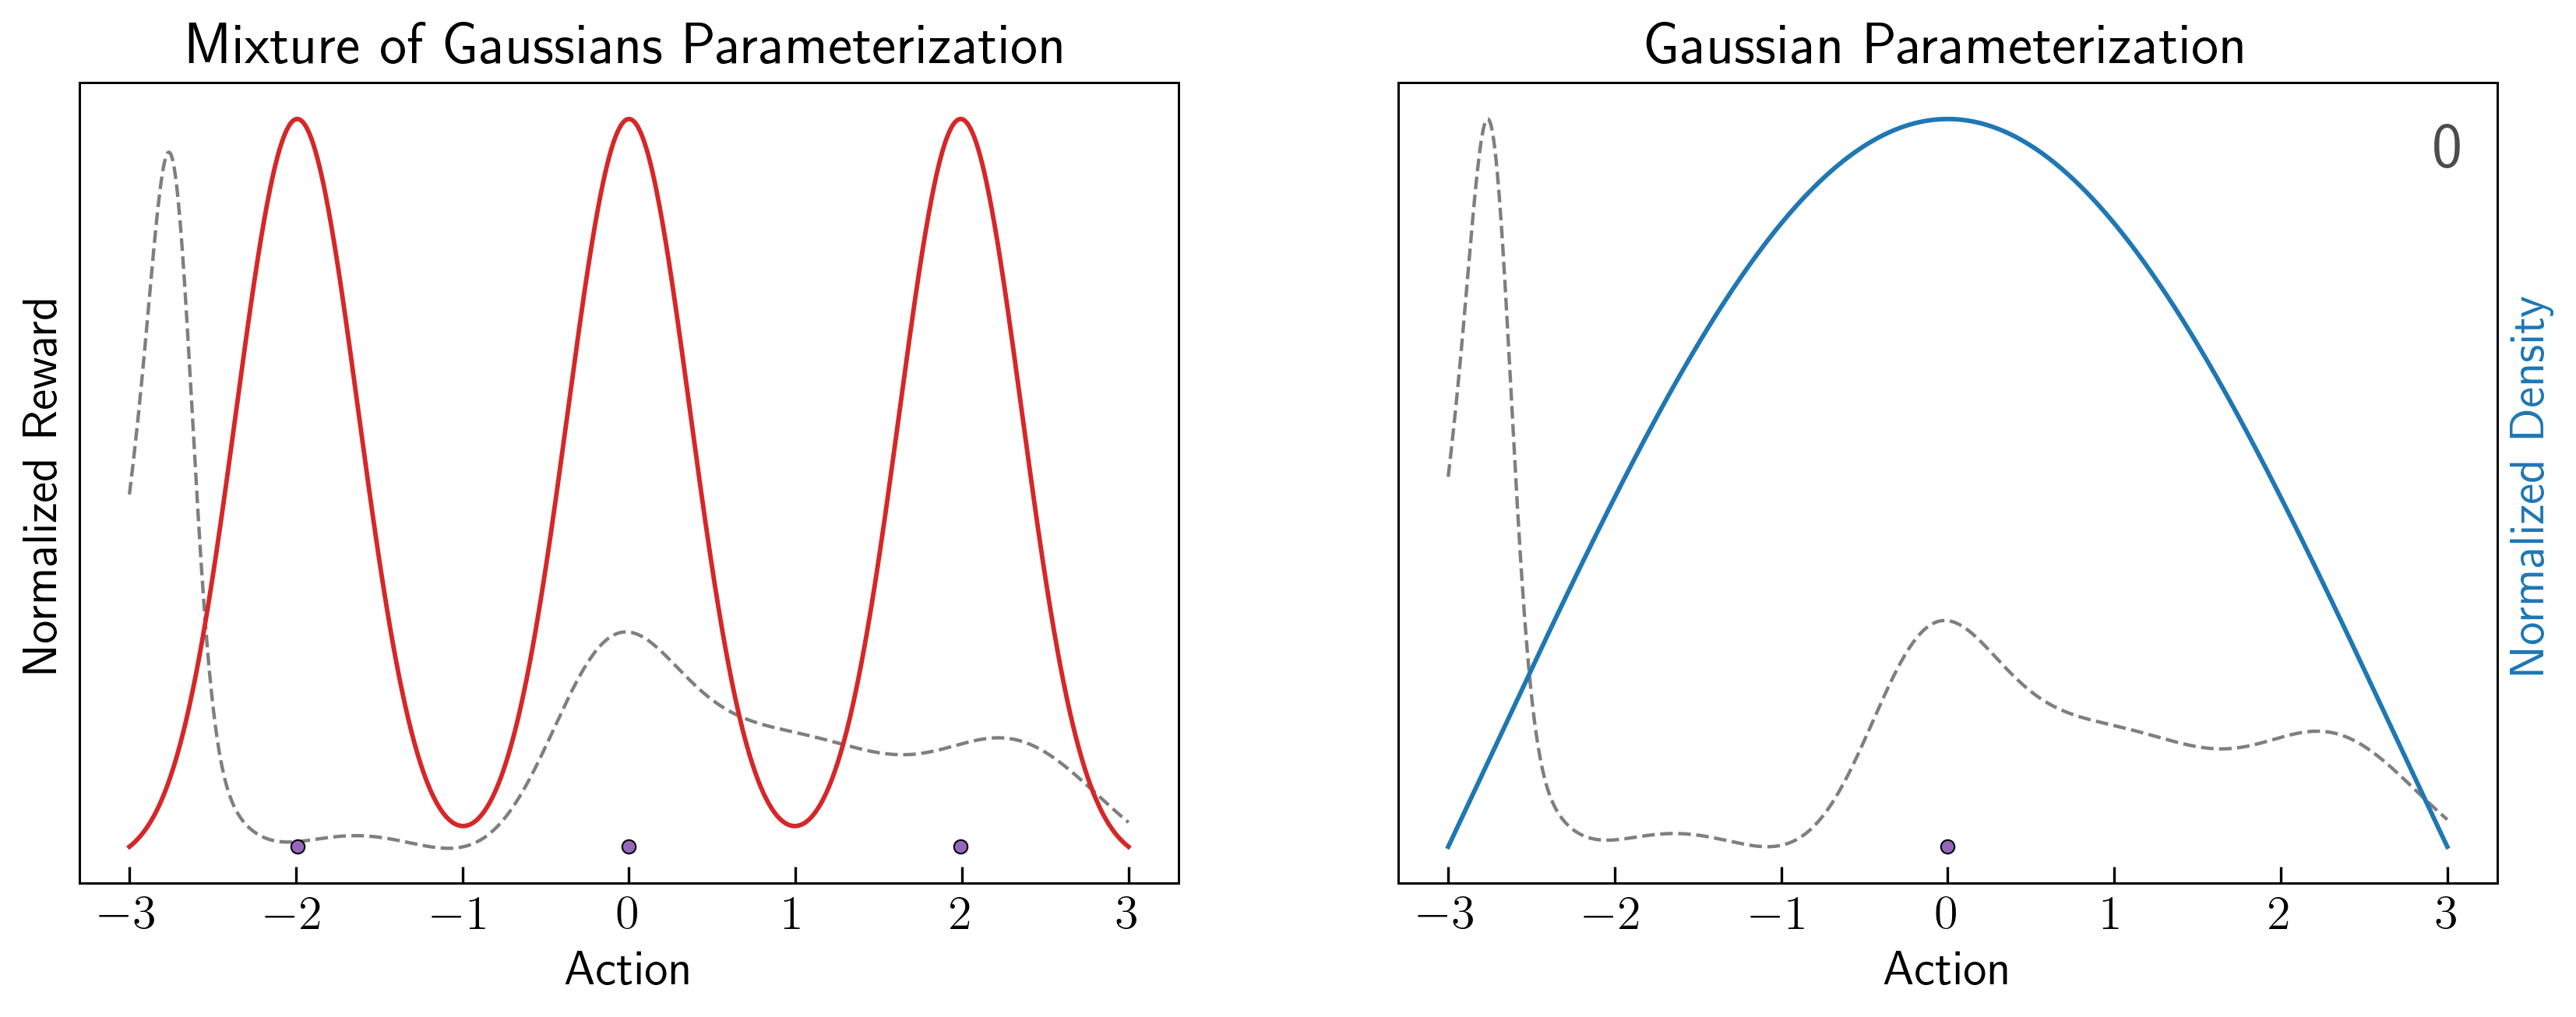

In [16]:
import json



data = db1.q("select means, stds, mixings from bandit_params where run=201").values

for step in range(1):
    a = data[step]
    means = json.loads(json.loads(a[0]))
    stds = json.loads(json.loads(a[1]))
    mixings = json.loads(json.loads(a[2]))



fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(13.35, 4.45), dpi=300)
# plot the reward function
x = np.linspace(-3, 3, 1000)
y = reward_function(x, means, stds, mixings)
axs[0].plot(x, (y-y.min())/(y.max() - y.min()), color='black', linewidth=lwidth*1.5, linestyle='--', alpha=0.5)
axs[1].plot(x, (y-y.min())/(y.max() - y.min()), color='black', linewidth=lwidth*1.5, linestyle='--', alpha=0.5)

ax2 = axs[0].twinx()
ax2.get_yaxis().set_visible(False)



color_idx=3
data = db1.q("select means, stds, mixings from learned_policy where run=201").values
for step in range(1):
    a = data[step]
    means = json.loads(json.loads(a[0]))
    stds = json.loads(json.loads(a[1]))
    mixings = json.loads(json.loads(a[2]))
    
y = np.exp(gaussian_mixture_log_prob(x, means, stds, mixings, num_components=3))
ax2.plot(x, (y-y.min())/(y.max() - y.min()), label='mixture', color=colors[color_idx], linewidth=lwidth*2, linestyle='-')
ax2.scatter(transform_mean(means),[0]*len(means),color=colors[4], marker='.', edgecolors='black', lw=0.5, s=70)



color_idx=0
data = db1.q("select means, stds, mixings from learned_policy where run=200").values
for step in range(1):
    a = data[step]
    means = json.loads(json.loads(a[0]))
    stds = json.loads(json.loads(a[1]))
    mixings = json.loads(json.loads(a[2]))


ax2 = axs[1].twinx()
y = np.exp(gaussian_log_prob(x, means, stds))
ax2.plot(x, (y-y.min())/(y.max() - y.min()), label='gaussian', color=colors[color_idx], linewidth=lwidth*2, linestyle='-')
ax2.scatter(transform_mean(means),[0]*len(means),color=colors[4], marker='.', edgecolors='black', lw=0.5, s=70)



axs[0].set_ylim(top=1.1)
axs[0].set_ylabel(fr'Normalized Reward')
axs[0].set_xlabel(fr'Action')
axs[1].set_xlabel(fr'Action')
axs[0].set_title("Mixture of Gaussians Parameterization")
axs[1].set_title("Gaussian Parameterization")
ax2.set_ylabel(fr'Normalized Density', color=colors[color_idx])
axs[1].get_yaxis().set_visible(False)
axs[0].set_yticks([], minor=False)
ax2.set_yticks([], minor=False)
fig.patch.set_alpha(0.)

left, width = .25, 0.72
bottom, height = .25, .7
right = left + width
top = bottom + height

axs[1].text(right, top, '0',
        horizontalalignment='right',
        verticalalignment='top',
        alpha=0.7,
        fontsize=20,
        transform=axs[1].transAxes)

plt.show()

In [17]:
import json
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] #= '/home/haseebs/workspace/envs/prod/lib/python3.10/site-packages/ffmpeg'

'ffmpeg'

processing seeds [1, 0]
processing seeds [3, 2]
processing seeds [5, 4]
processing seeds [7, 6]
processing seeds [9, 8]
processing seeds [11, 10]


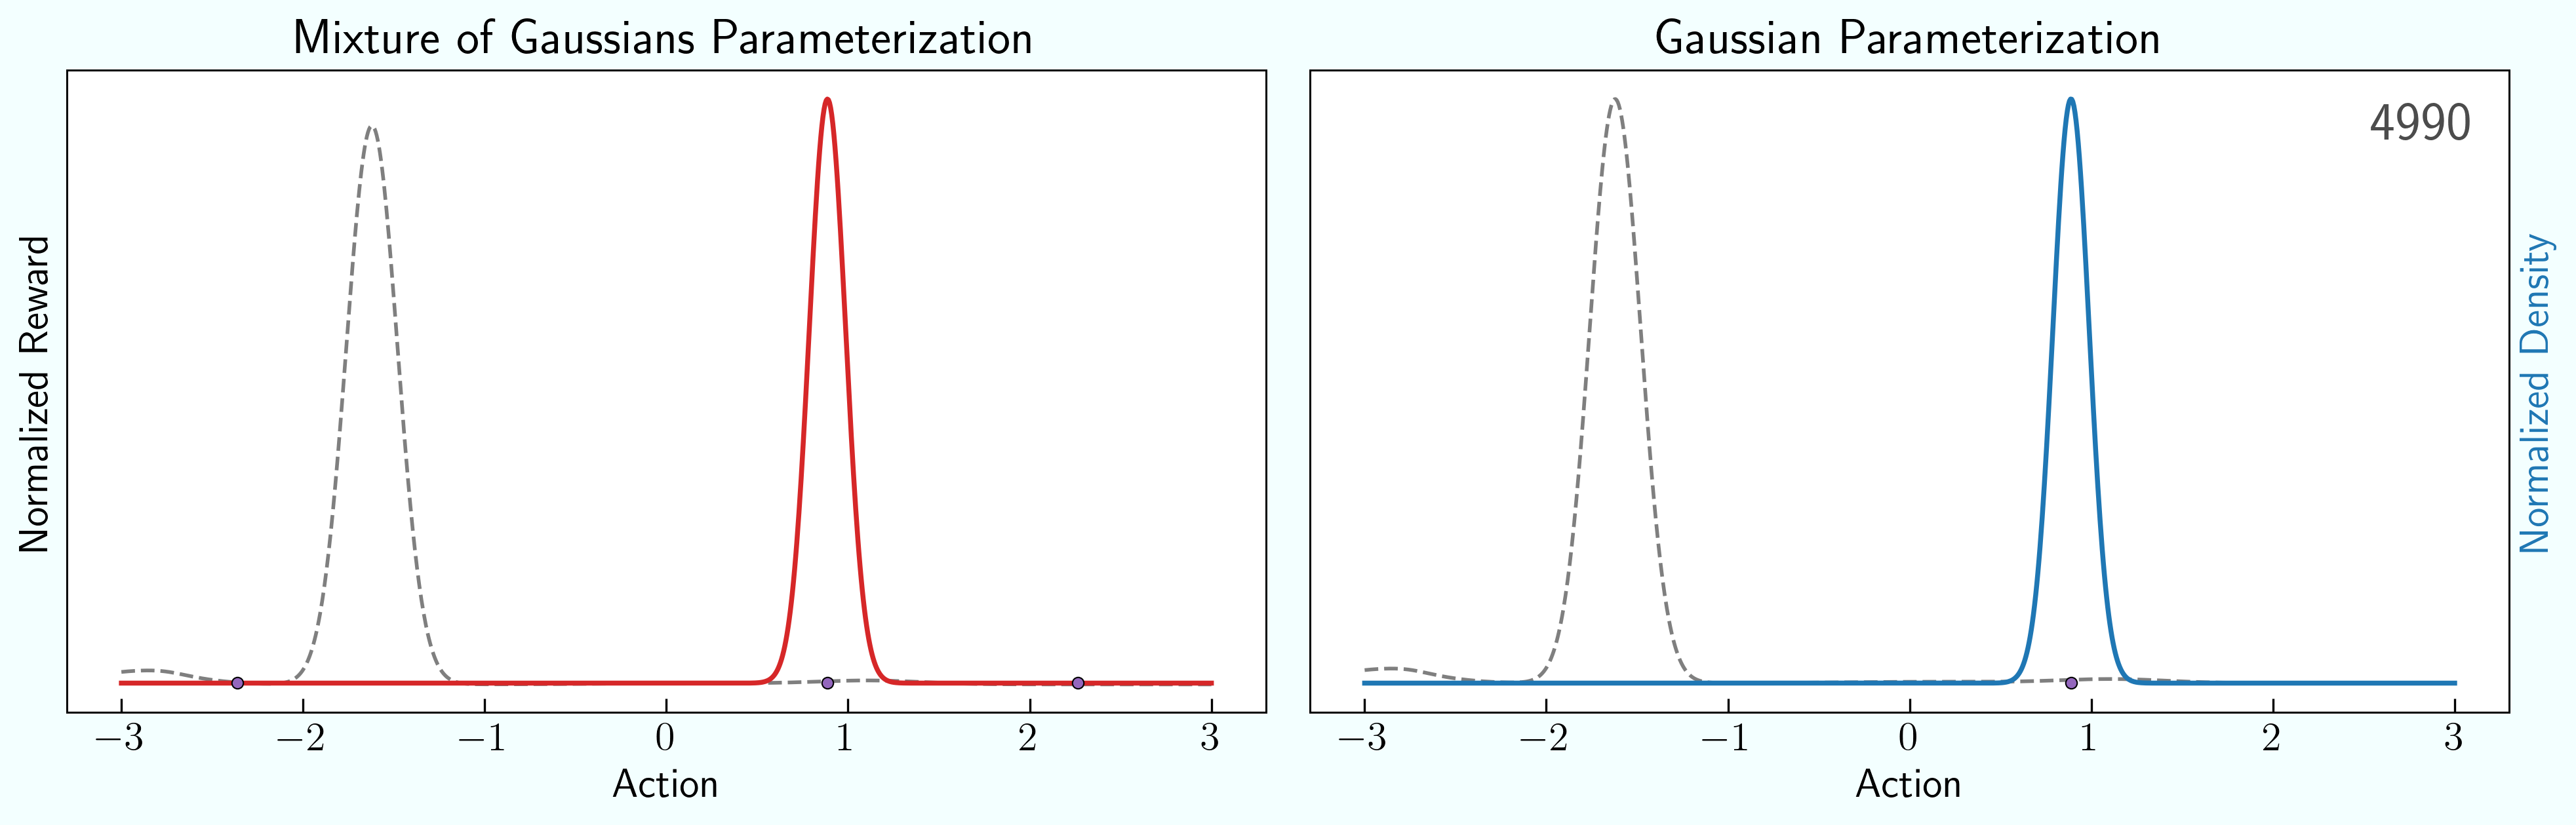

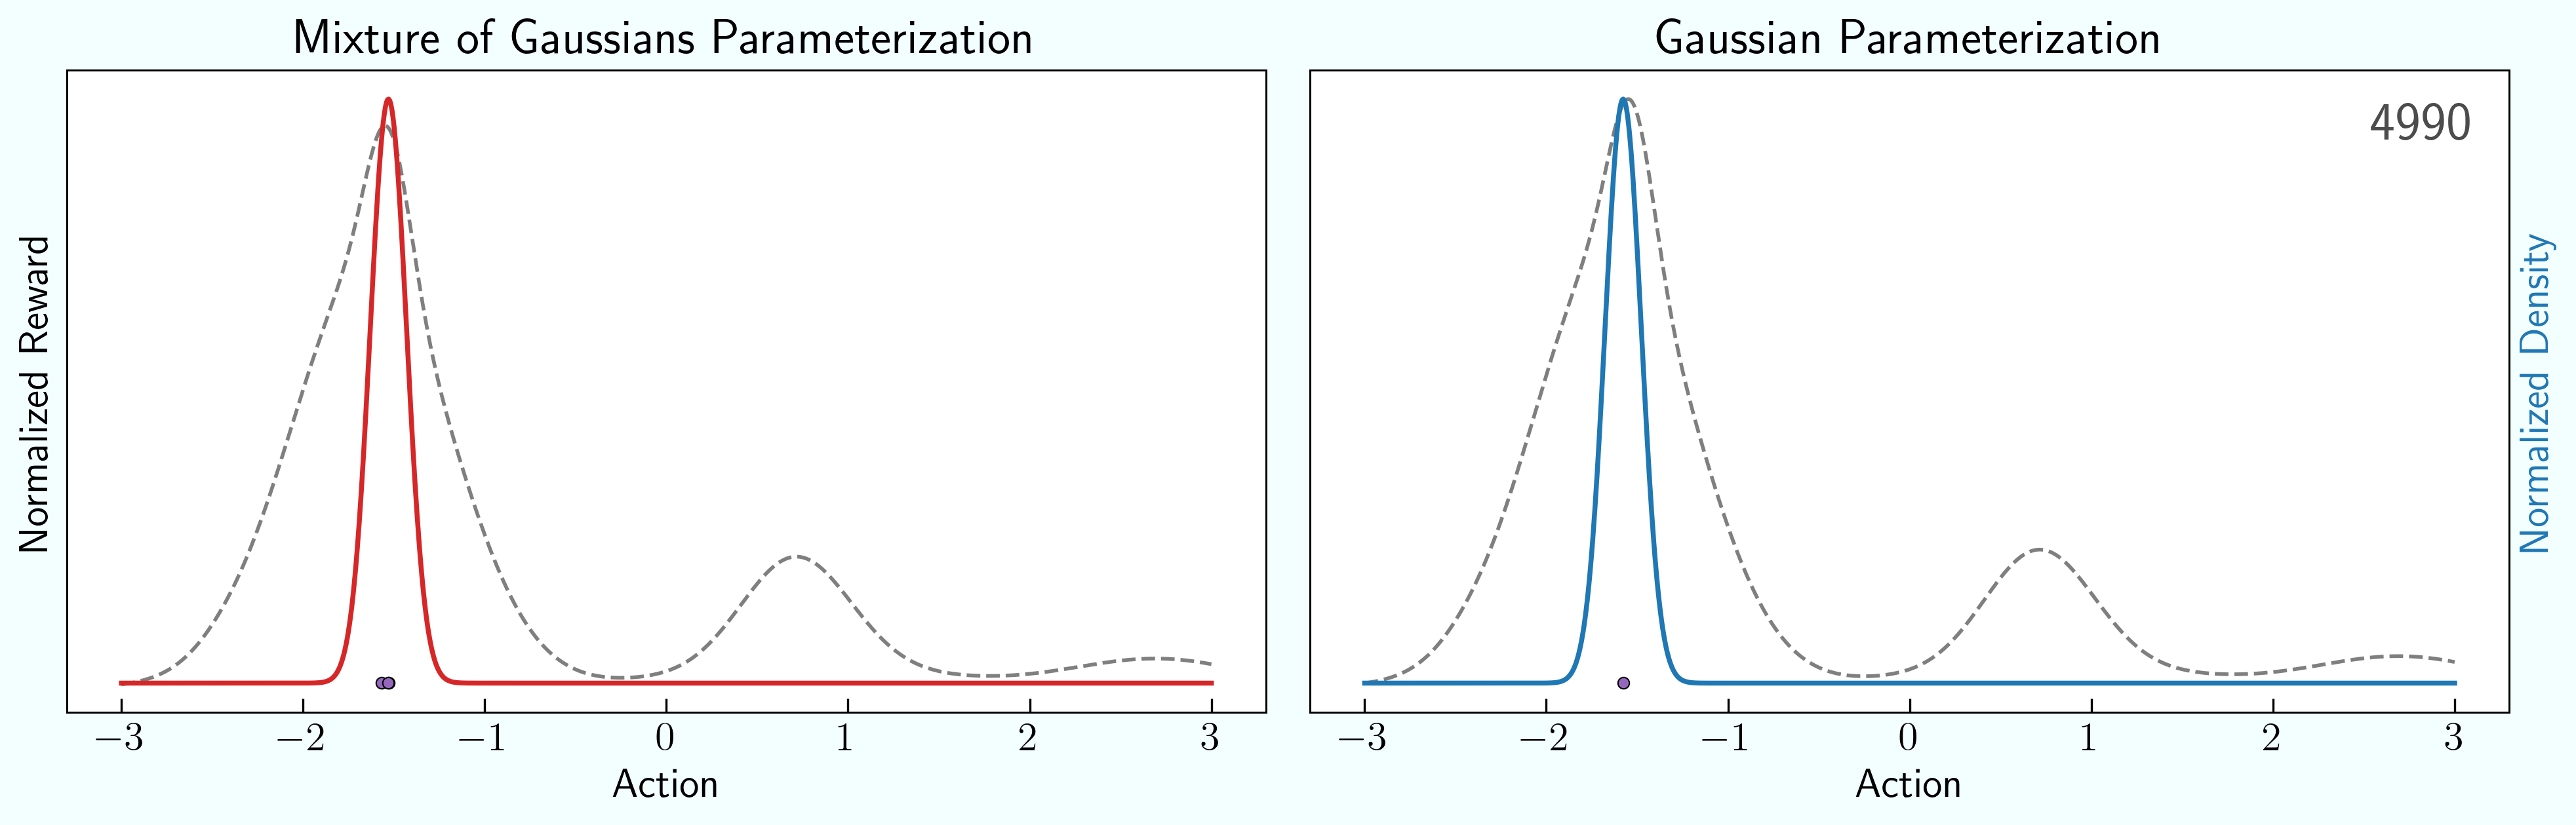

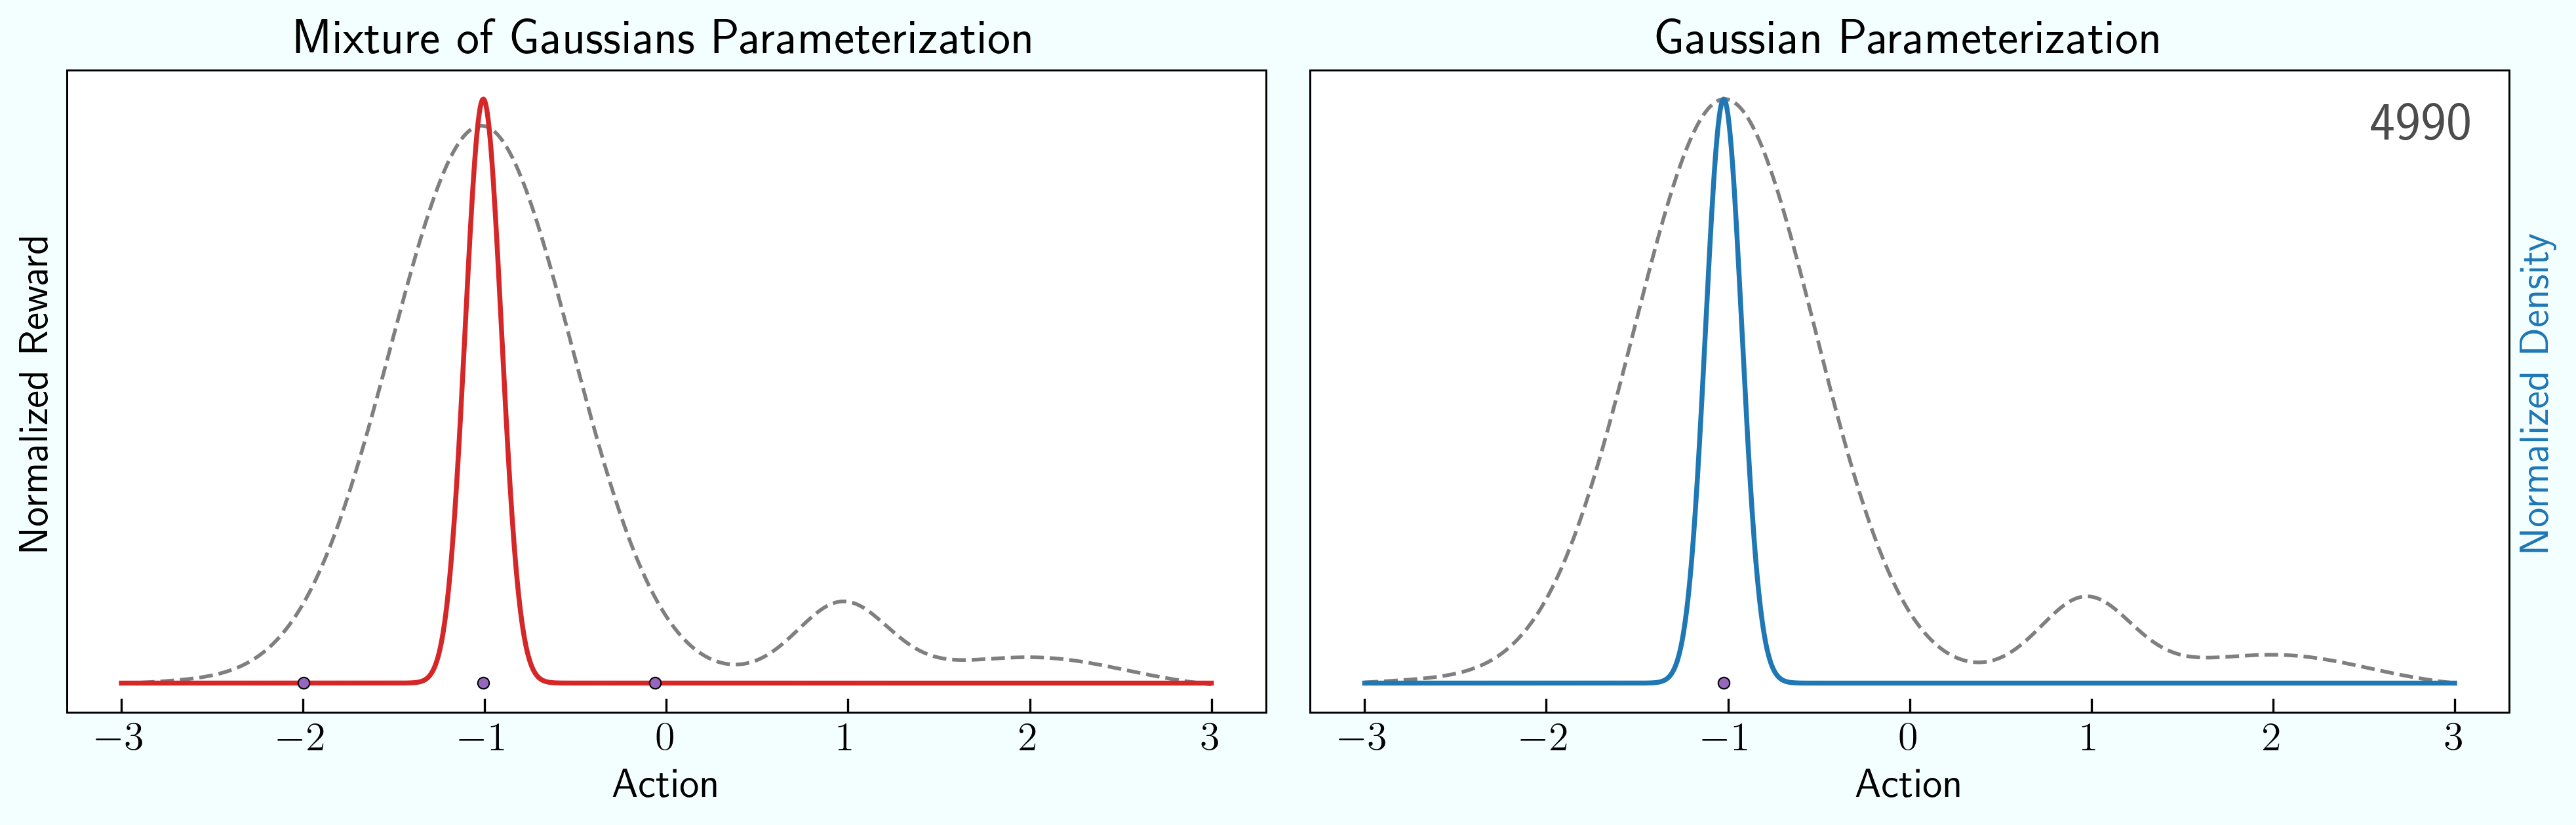

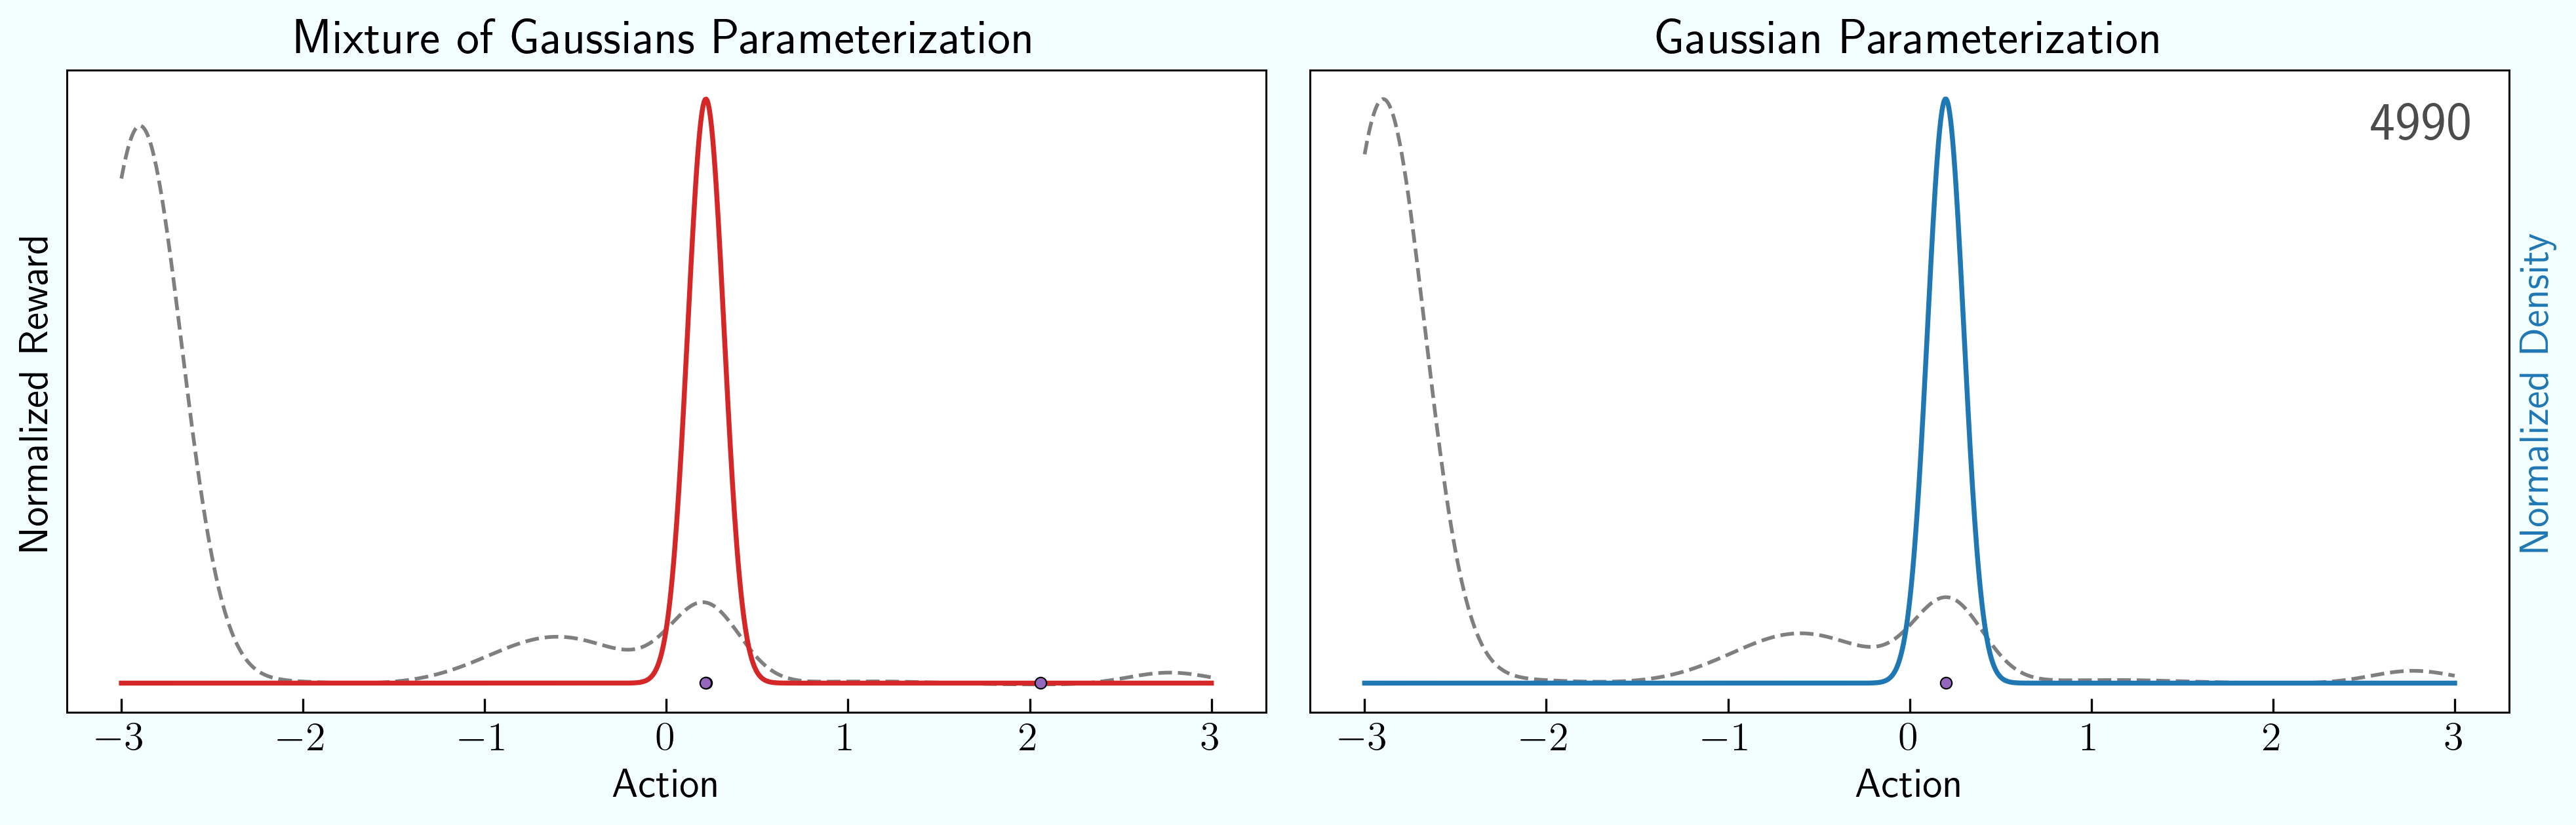

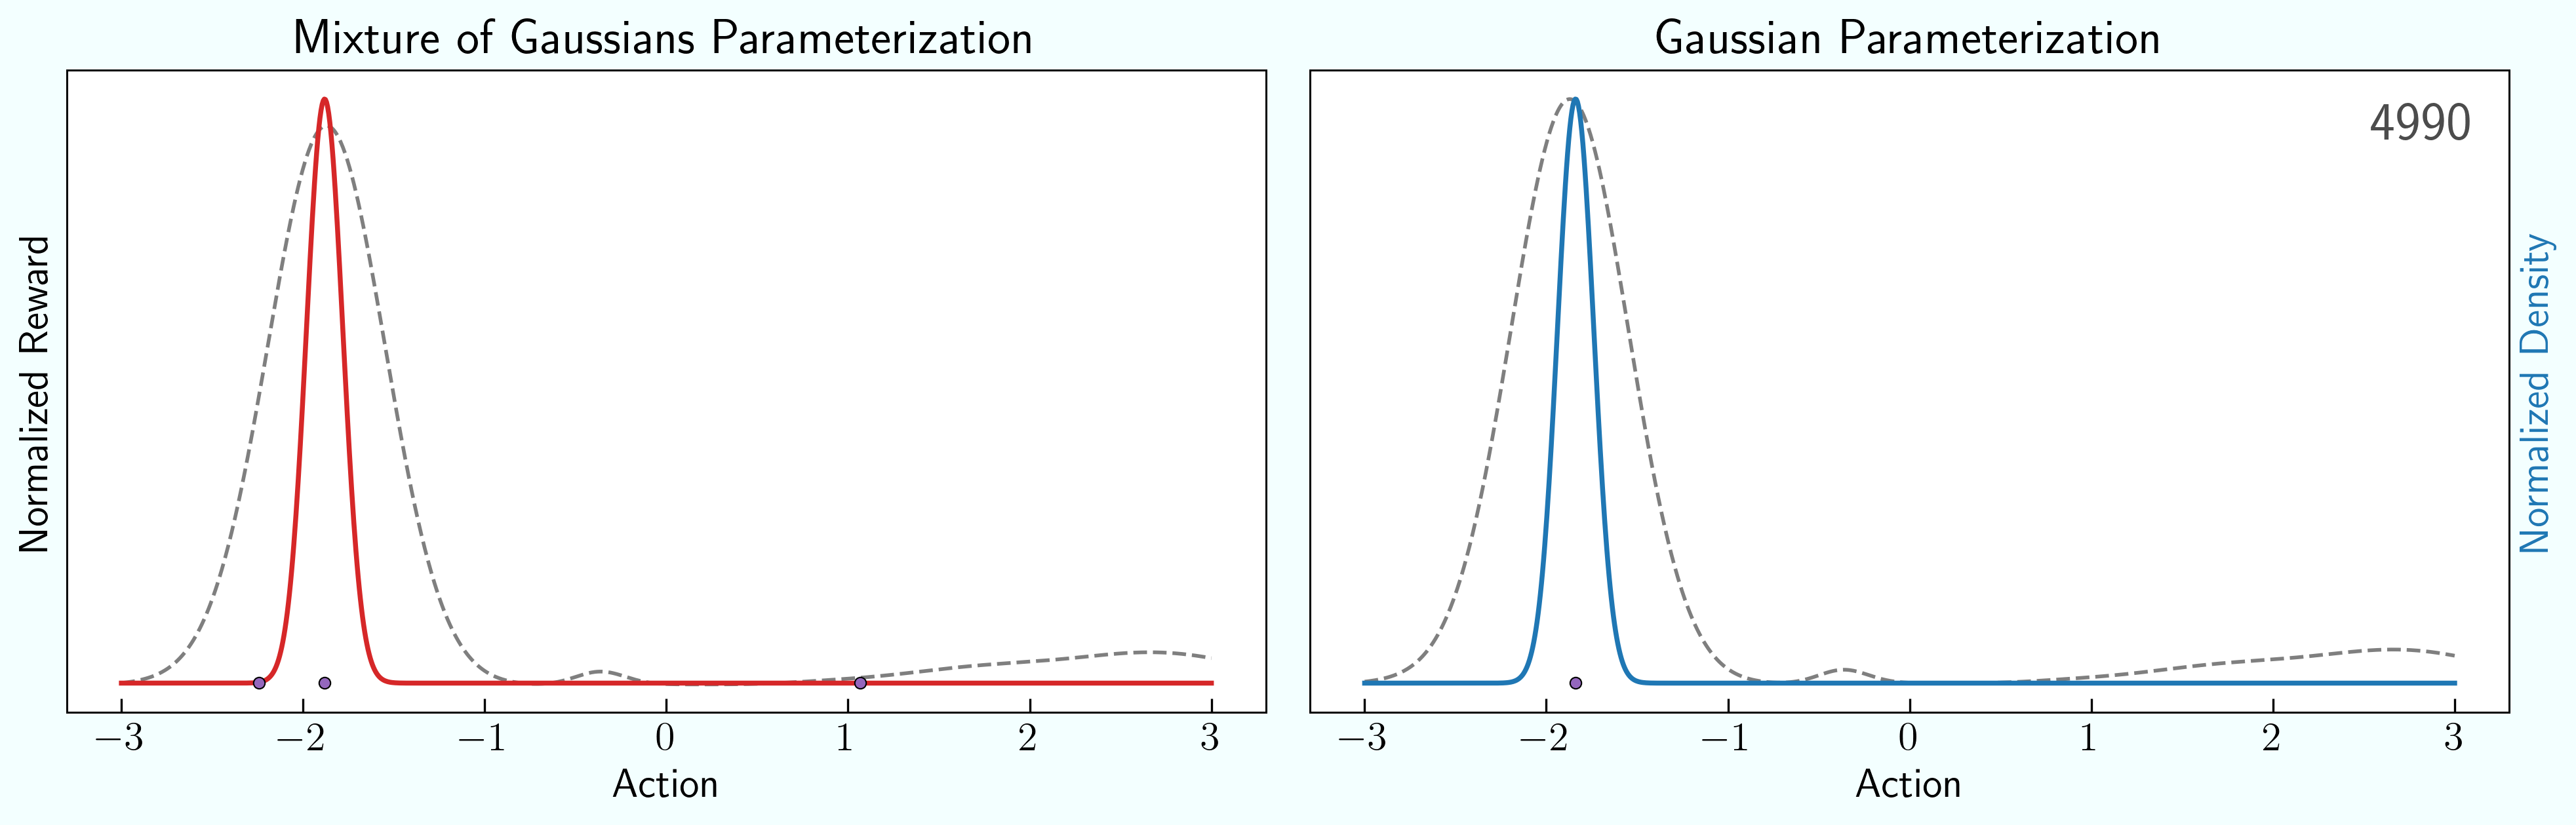

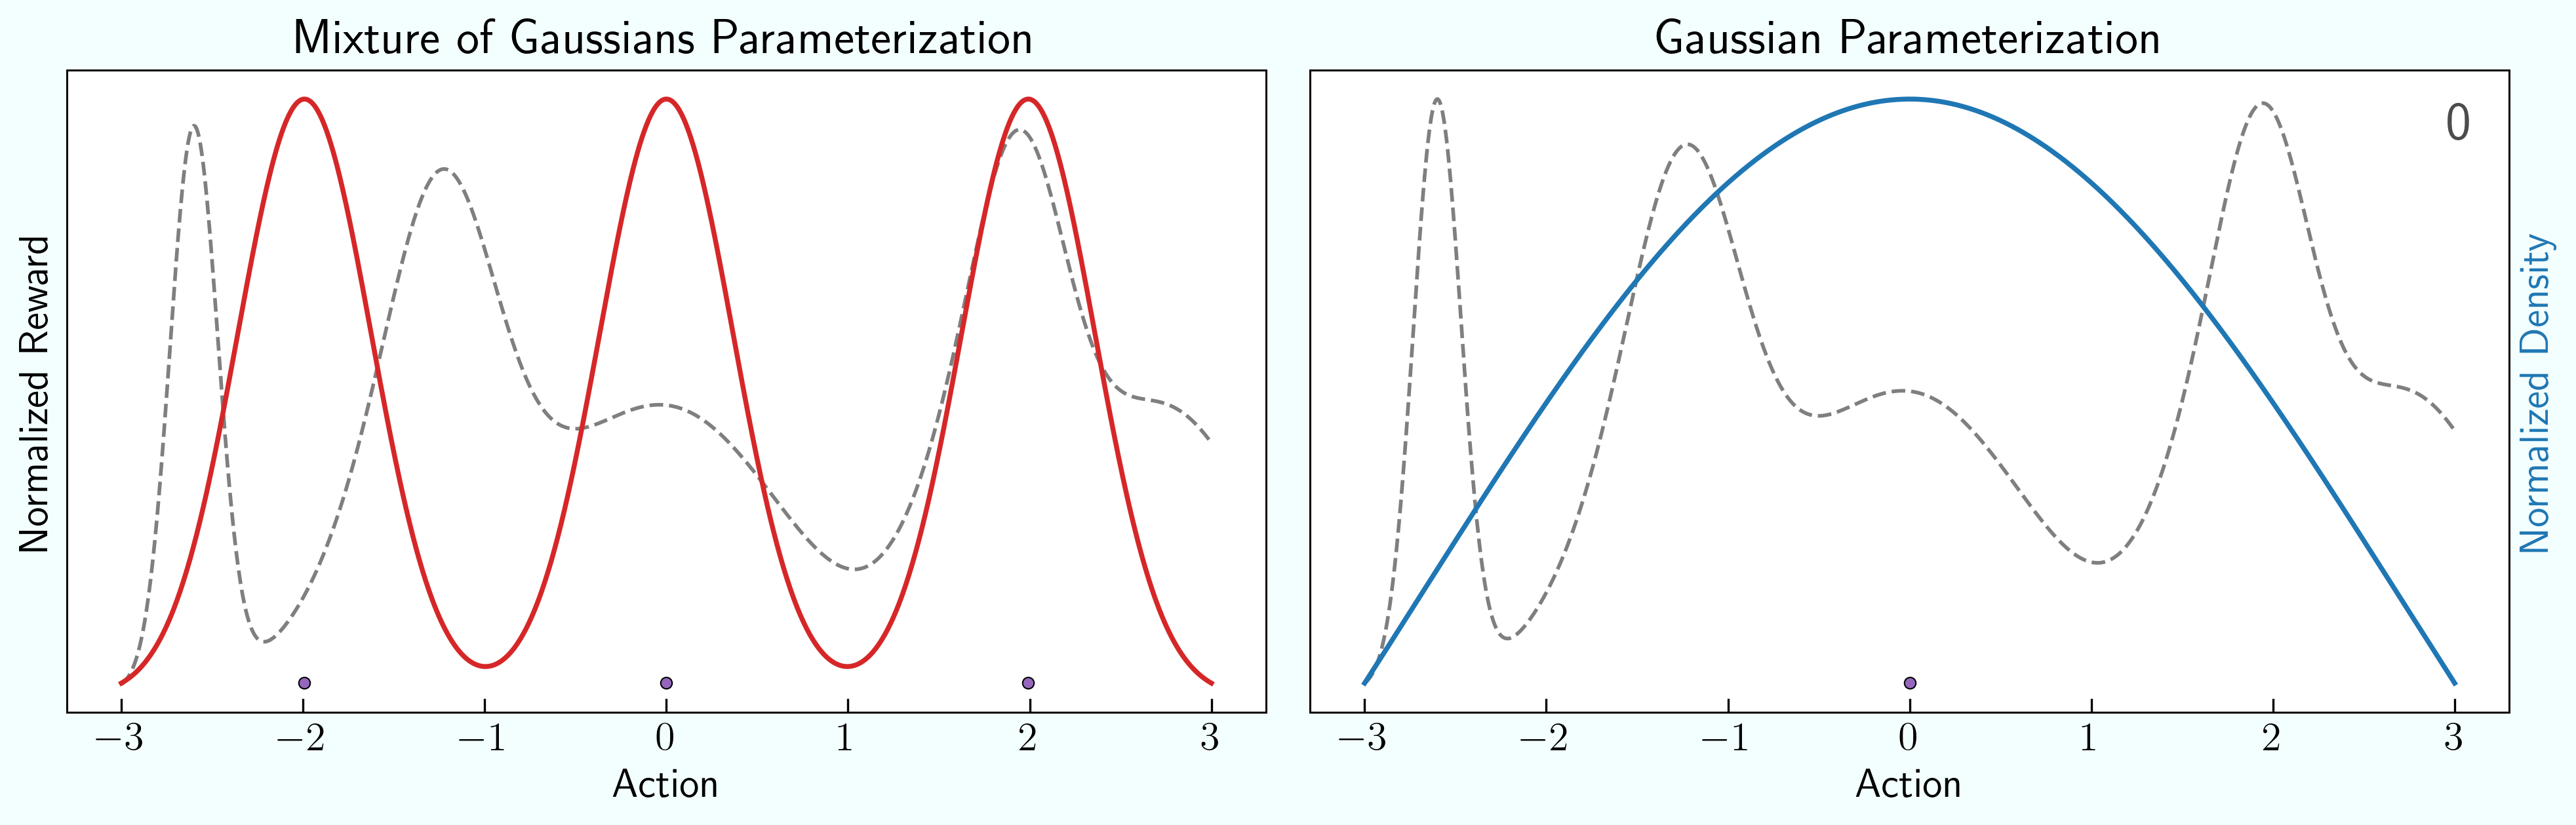

In [18]:
import json


for seed in [[1,0],
             [3,2],
             [5,4],
             [7,6],
             [9,8],
             [11,10]
            ]:
    print(f"processing seeds {seed}")
    
    #### video settings
    # moving avg window size to smooth out the lines (1=no smoothing_
    moving_avg_window_size = 1
    # number of additional interpolated frames to add between each
    # step's flow to smooth out the transitions
    n_interp = 1
    fps = 24
    
    lwidth = 0.9
    color_idx = 0
    
    # collect data
    steps=500
    data = db1.q(f"select means, stds, mixings from bandit_params where run={seed[0]}").values
    bandit_vec = []
    for step in range(steps):
        a = data[step]
        means = json.loads(json.loads(a[0]))
        stds = json.loads(json.loads(a[1]))
        mixings = json.loads(json.loads(a[2]))
        bandit_vec.append([means,stds,mixings])
    
    mixture_vec = []
    data = db1.q(f"select means, stds, mixings from learned_policy where run={seed[0]}").values
    for step in range(steps):
        a = data[step]
        means = json.loads(json.loads(a[0]))
        stds = json.loads(json.loads(a[1]))
        mixings = json.loads(json.loads(a[2]))
        mixture_vec.append([means,stds,mixings])
    
    gaussian_vec = []
    data = db1.q(f"select means, stds, mixings from learned_policy where run={seed[1]}").values
    for step in range(steps):
        a = data[step]
        means = json.loads(json.loads(a[0]))
        stds = json.loads(json.loads(a[1]))
        mixings = json.loads(json.loads(a[2]))
        gaussian_vec.append([means,stds])
    
    
    # plot step 0
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(13.35, 4.45), dpi=300)
    
    # plot the reward function
    x = np.linspace(-3, 3, 1000)
    y = reward_function(x, *bandit_vec[0])
    b1 = axs[0].plot(x, (y-y.min())/(y.max() - y.min()), color='black', linewidth=lwidth*1.5, linestyle='--', alpha=0.5)
    b2 = axs[1].plot(x, (y-y.min())/(y.max() - y.min()), color='black', linewidth=lwidth*1.5, linestyle='--', alpha=0.5)
    ax2 = axs[0].twinx()
    ax2.get_yaxis().set_visible(False)
    
    color_idx=3
    y = np.exp(gaussian_mixture_log_prob(x, *mixture_vec[0], num_components=3))
    m1 = ax2.plot(x, (y-y.min())/(y.max() - y.min()), label='mixture', color=colors[color_idx], linewidth=lwidth*2, linestyle='-')
    m2 = ax2.scatter(transform_mean(mixture_vec[0][0]),[0]*len(mixture_vec[0][0]),color=colors[4], marker='.', edgecolors='black', lw=0.5, s=70, zorder=2)
    
    
    color_idx=0
    ax2 = axs[1].twinx()
    y = np.exp(gaussian_log_prob(x, *gaussian_vec[0]))
    g1 = ax2.plot(x, (y-y.min())/(y.max() - y.min()), label='gaussian', color=colors[color_idx], linewidth=lwidth*2, linestyle='-')
    g2 = ax2.scatter(transform_mean(gaussian_vec[0][0]),[0]*len(gaussian_vec[0][0]),color=colors[4], marker='.', edgecolors='black', lw=0.5, s=70, zorder=2)
    
    
    # print timestep
    left, width = .25, 0.72
    bottom, height = .25, .7
    right = left + width
    top = bottom + height
    t = axs[1].text(right, top, '0',
            horizontalalignment='right',
            verticalalignment='top',
            alpha=0.7,
            fontsize=20,
            transform=axs[1].transAxes)
    
    axs[0].set_ylim(top=1.1)
    axs[0].set_ylabel(fr'Normalized Reward')
    axs[0].set_xlabel(fr'Action')
    axs[1].set_xlabel(fr'Action')
    axs[0].set_title("Mixture of Gaussians Parameterization")
    axs[1].set_title("Gaussian Parameterization")
    ax2.set_ylabel(fr'Normalized Density', color=colors[color_idx])
    axs[1].get_yaxis().set_visible(False)
    axs[0].set_yticks([], minor=False)
    ax2.set_yticks([], minor=False)
    #xs.set_facecolor("#F3FFFF")
    fig.set_facecolor("#F3FFFF")
    # end of step 0 plot
    
    
    # function to fetch data at each frame
    def update(frame):
        # update rl curve
        y = np.exp(gaussian_mixture_log_prob(x, *mixture_vec[frame], num_components=3))
        m1[0].set_ydata((y-y.min())/(y.max() - y.min()))
        y = np.exp(gaussian_log_prob(x, *gaussian_vec[frame]))
        g1[0].set_ydata((y-y.min())/(y.max() - y.min()))
        y = reward_function(x, *bandit_vec[frame])
        b1[0].set_ydata((y-y.min())/(y.max() - y.min()))
        b2[0].set_ydata((y-y.min())/(y.max() - y.min()))
        m2.set_offsets(np.c_[ transform_mean(mixture_vec[frame][0]), [0] * len(mixture_vec[frame][0])])
        g2.set_offsets(np.c_[ transform_mean(gaussian_vec[frame][0]), [0] * len(gaussian_vec[frame][0])])
        t.set_text(frame*10)
        return (m1[0], g1[0], b1[0], b2[0], m2, g2, t)
    
    
    # animate
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps, interval=10, save_count=steps)
    plt.tight_layout()
    
    FFwriter = animation.FFMpegWriter(fps=fps)
    s = ani.save(f'561_rl1_reinforce_best_non_smooth{seed[0]}.mp4', writer = FFwriter,  savefig_kwargs={"transparent": False, "facecolor": "#F3FFFF"})


processing seeds [1, 0]


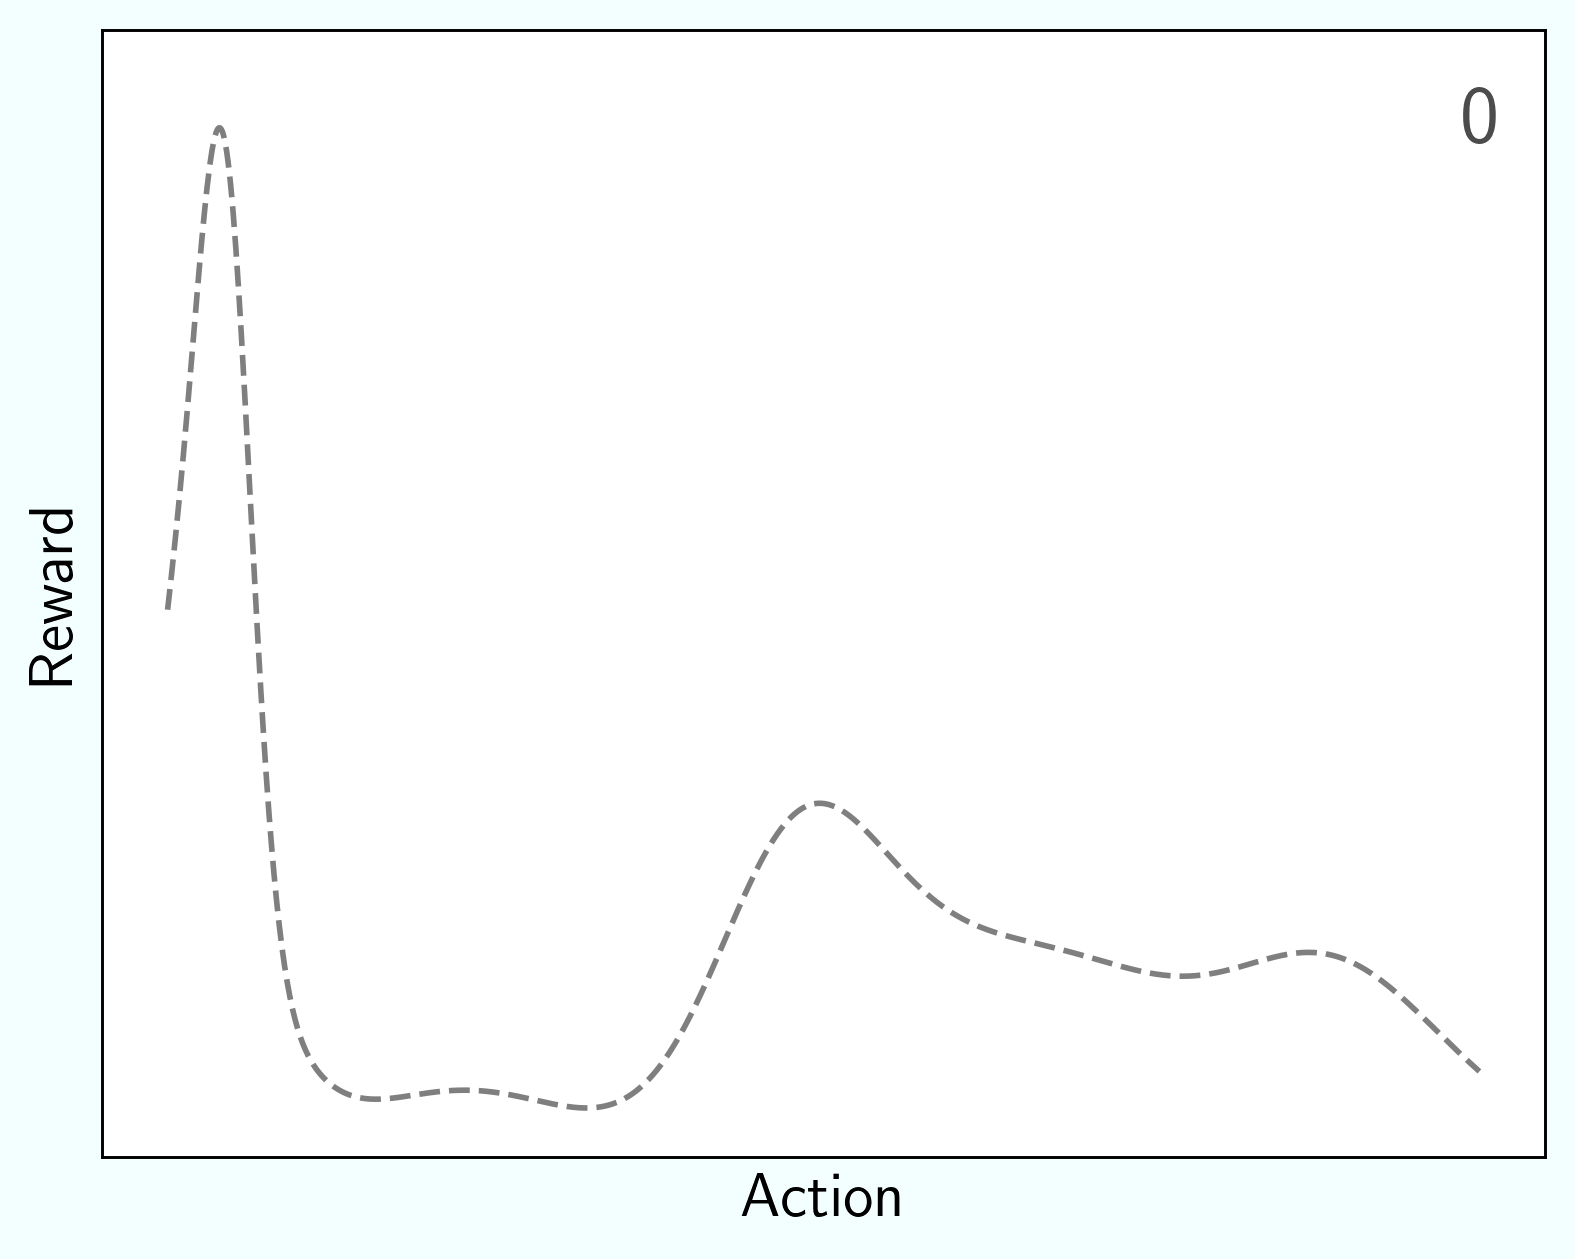

In [22]:
import json


for seed in [[1,0],]:
    print(f"processing seeds {seed}")
    
    #### video settings
    # moving avg window size to smooth out the lines (1=no smoothing_
    moving_avg_window_size = 1
    # number of additional interpolated frames to add between each
    # step's flow to smooth out the transitions
    n_interp = 1
    fps = 24
    
    lwidth = 0.9
    color_idx = 0
    
    # collect data
    steps=500
    data = db1.q(f"select means, stds, mixings from bandit_params where run={seed[0]}").values
    bandit_vec = []
    for step in range(steps):
        a = data[step]
        means = json.loads(json.loads(a[0]))
        stds = json.loads(json.loads(a[1]))
        mixings = json.loads(json.loads(a[2]))
        bandit_vec.append([means,stds,mixings])
    
    # plot step 0
    fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(5.5, 4.45), dpi=300)
    
    # plot the reward function
    x = np.linspace(-3, 3, 1000)
    y = reward_function(x, *bandit_vec[0])
    b1 = axs.plot(x, (y-y.min())/(y.max() - y.min()), color='black', linewidth=lwidth*1.5, linestyle='--', alpha=0.5)
    
    # print timestep
    left, width = .25, 0.72
    bottom, height = .25, .7
    right = left + width
    top = bottom + height
    t = axs.text(right, top, '0',
            horizontalalignment='right',
            verticalalignment='top',
            alpha=0.7,
            fontsize=20,
            transform=axs.transAxes)


    axs.set_ylim(top=1.1)
    axs.set_ylabel(fr'Reward')
    axs.set_xlabel(fr'Action')
    axs.set_yticks([], minor=False)
    axs.set_xticks([], minor=False)
    
    ax2.set_yticks([], minor=False)

    #xs.set_facecolor("#F3FFFF")
    fig.set_facecolor("#F3FFFF")
    # end of step 0 plot
    
    
    # function to fetch data at each frame
    def update(frame):
        # update rl curve
        y = reward_function(x, *bandit_vec[frame])
        b1[0].set_ydata((y-y.min())/(y.max() - y.min()))
        t.set_text(frame*10)
        return (b1[0],t)
    
    
    # animate
    ani = animation.FuncAnimation(fig=fig, func=update, frames=steps, interval=10, save_count=steps)
    plt.tight_layout()
    
    FFwriter = animation.FFMpegWriter(fps=fps)
    s = ani.save(f'nonstationary_smooth_env.mp4', writer = FFwriter,  savefig_kwargs={"transparent": False, "facecolor": "#F3FFFF"})
